In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import datagen
from utils import datatreat
from utils import solve_ridge
from utils import tau_GD
from utils import CGD
from utils import SCGD
from utils import GD

In [2]:
np.random.seed(1)

In [3]:
A_,y_ = datagen()
n,p,n_train,n_test,A,y,A_test,y_test = datatreat(A_,y_,128)
lbd=0.025

Number of obs: 173
n train: 128
n test: 45
Number of explicative variables: 9


In [4]:
def mse(x): return 0.5*np.linalg.norm(A@x-y)**2/n_train + 0.5*lbd*np.linalg.norm(x)**2

def dmse_j(x,ind):
    A_=np.zeros((p,n_train))
    A_[ind]=A.T[ind]
    x_=np.zeros(p)
    x_[ind]=x[ind]
    return A_@(A@x-y)/n_train + lbd*x_

def dmse_i_j(x,ind_i,ind_j):
    batch_size=ind_i.size
    Ai=A[ind_i]
    yi=y[ind_i]
    
    A_ij=np.zeros((p,batch_size))
    A_ij[ind_j]=Ai.T[ind_j]
    x_j=np.zeros(p)
    x_j[ind_j]=x[ind_j]
    
    return A_ij@(Ai@x-yi)/batch_size + lbd*x_j

In [5]:
x_star,f_star=solve_ridge(A,y,lbd)

N_fbi=200 #full block iterate: 1 iter GD = 1fbi, 1 iter CGD = 1/p fbi

tau_max,tau_opt=tau_GD(A,lbd)

x_0=np.zeros(p)

block_size=np.arange(1,p+1)
N_block_size = block_size.size

In [6]:
xCGD=[None]*N_block_size
errCGD=[None]*N_block_size

N_rep=50
score=np.zeros((N_rep,N_block_size))

for j in range(N_rep):
    score_j=np.zeros(N_block_size)
    for i in range(N_block_size):
        N_iter=int(N_fbi*p/block_size[i])
        xCGD[i],fCGD=CGD(tau_opt,x_0,n_train,mse,dmse_j,N_iter,block_size[i])
        errCGD[i]=np.linalg.norm(xCGD[i]-x_star,axis=1)
        score_j[i]=errCGD[i][-1]
    score[j]= N_block_size - np.argsort(score_j)

print(np.round(np.mean(score,axis=0),2))

[6.32 5.56 5.74 5.16 5.26 4.86 4.64 4.44 3.02]


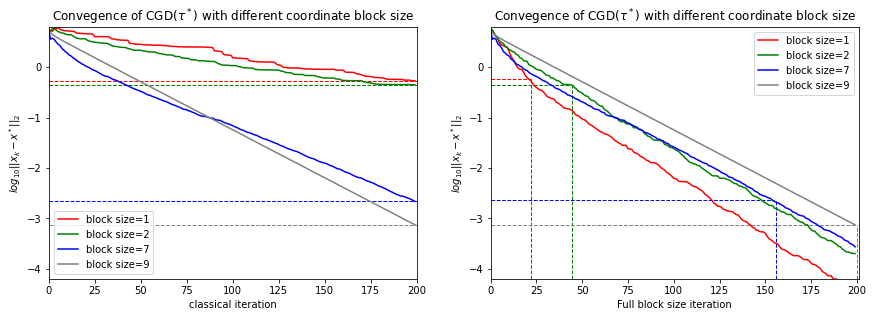

In [7]:
fig, (ax0,ax1) = plt.subplots(nrows=1,ncols=2)

block_size=np.array([1,2,7,9])
color=['red','green','blue','grey']
N_block_size = block_size.size

xCGD=[None]*N_block_size
errCGD=[None]*N_block_size

for i in range(N_block_size):
    N_iter=int(N_fbi*p/block_size[i])
    xCGD[i],fCGD=CGD(tau_opt,x_0,n_train,mse,dmse_j,N_iter,block_size[i])
    errCGD[i]=np.linalg.norm(xCGD[i]-x_star,axis=1)
    ind_iter=np.linspace(0,N_iter-1,N_fbi).astype(int)
    ax0.plot(np.log10(errCGD[i][:N_fbi]),label='block size=%.0f'%block_size[i],color=color[i])
    ax0.hlines(np.log10(errCGD[i][N_fbi-1]),color=color[i],linestyle='--', linewidth=1, 
              xmin=0,xmax=N_fbi)
    ax1.vlines(N_fbi*block_size[i]/p,color=color[i],linestyle='--', linewidth=1, 
               ymin=-4.2,ymax=np.log10(errCGD[i][ind_iter[int(N_fbi*block_size[i]/p)-1]]))
    ax1.hlines(np.log10(errCGD[i][ind_iter[int(N_fbi*block_size[i]/p)-1]]),color=color[i],linestyle='--', linewidth=1, 
              xmin=0,xmax=int(N_fbi*block_size[i]/p))
    ax1.plot(np.log10(errCGD[i][ind_iter]),label='block size=%.0f'%block_size[i],color=color[i])

ax0.set_ylim(-4.2,.8)
ax0.set_xlim(0,N_fbi)
ax0.set_xlabel("classical iteration")
ax0.set_ylabel("$log_{10}||x_k-x^*||_2$")
ax0.set_title("Convegence of CGD($τ^*$) with different coordinate block size")
ax0.legend()

ax1.set_ylim(-4.2,.8)
ax1.set_xlim(0,N_fbi+1)
ax1.set_xlabel("Full block size iteration")
ax1.set_ylabel("$log_{10}||x_k-x^*||_2$")
ax1.set_title("Convegence of CGD($τ^*$) with different coordinate block size")
ax1.legend(loc='upper right')

plt.subplots_adjust(left=None, bottom=None, right=2, top=1, wspace=None, hspace=None)

In [8]:
M=200

xGD,fxGD=SCGD(tau_opt,x_0,n_train,mse,dmse_i_j,M,n_train,p)
errGD=np.linalg.norm(xGD-x_star,axis=1)

batch_size_SGD=16
n_iter_SGD=int(M*n_train/batch_size_SGD)
tau_SGD=tau_max/(np.arange(1,n_iter_SGD+1))**0.5
xSGD,fxSGD=SCGD(tau_SGD,x_0,n_train,mse,dmse_i_j,n_iter_SGD,batch_size_SGD,p)
errSGD=np.linalg.norm(xSGD-x_star,axis=1)

block_size_CGD=1
n_iter_CGD=int(M*(p-block_size_CGD+1))
xCGD,fxCGD=SCGD(tau_opt,x_0,n_train,mse,dmse_i_j,n_iter_CGD,n_train,block_size_CGD)
errCGD=np.linalg.norm(xCGD-x_star,axis=1)

batch_size_SCGD=16
block_size_SCGD=3
n_iter_SCGD=int(M*n_train/batch_size_SCGD*(p-block_size_SCGD))
tau_SCGD=tau_max/(np.arange(1,n_iter_SCGD+1))**0.5
xSCGD,fxSCGD=SCGD(tau_SCGD,x_0,n_train,mse,dmse_i_j,n_iter_SCGD,batch_size_SCGD,block_size_SCGD)
errSCGD=np.linalg.norm(xSCGD-x_star,axis=1)

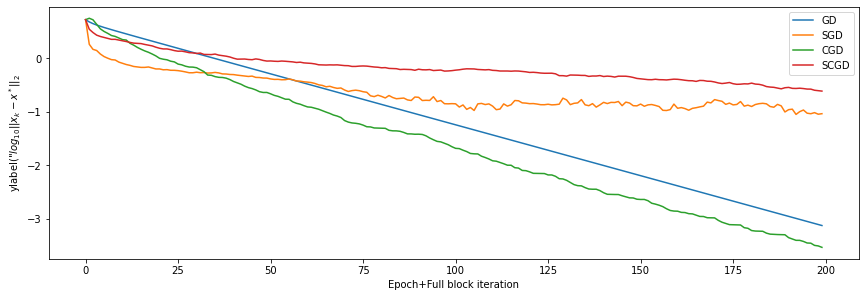

In [9]:

ind_SGD=np.linspace(0,n_iter_SGD-1,M).astype(int)
ind_CGD=np.linspace(0,n_iter_CGD-1,M).astype(int)
ind_SCGD=np.linspace(0,n_iter_SCGD-1,M).astype(int)

plt.plot(np.log10(errGD),label="GD")
plt.plot(np.log10(errSGD[ind_SGD]),label="SGD")
plt.plot(np.log10(errCGD[ind_CGD]),label="CGD")
plt.plot(np.log10(errSCGD[ind_SCGD]),label="SCGD")
plt.xlabel('Epoch+Full block iteration')
plt.ylabel('ylabel("$log_{10}||x_k-x^*||_2$')
ax1.set_title("Convegence of the x error")
plt.legend()

plt.subplots_adjust(left=None, bottom=None, right=2, top=1, wspace=None, hspace=None)